# Análise Exploratória de Dados (EDA) - House Prices

Este notebook contém uma análise exploratória detalhada do dataset "House Prices: Advanced Regression Techniques" do Kaggle. A EDA visa compreender as principais variáveis, detectar outliers, e obter insights iniciais antes da modelagem.

---

## 📥 1. Carregamento dos Dados

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Configurações estéticas
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
%matplotlib inline

# Carregando os dados
df = pd.read_csv("/home/akel/PycharmProjects/Kaggle/HousePrices/data/train.csv")

df.shape, df.columns[:10]

((1460, 81),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities'],
       dtype='object'))

---

## 🧮 2. Visão Geral e Estatísticas Básicas



In [5]:
# Visualização geral
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


```markdown
📌 **Nota:** O dataset possui variáveis contínuas e categóricas. Vamos investigar separadamente as mais relevantes.
```

---

## 📉 3. Análise da Variável Alvo - SalePrice

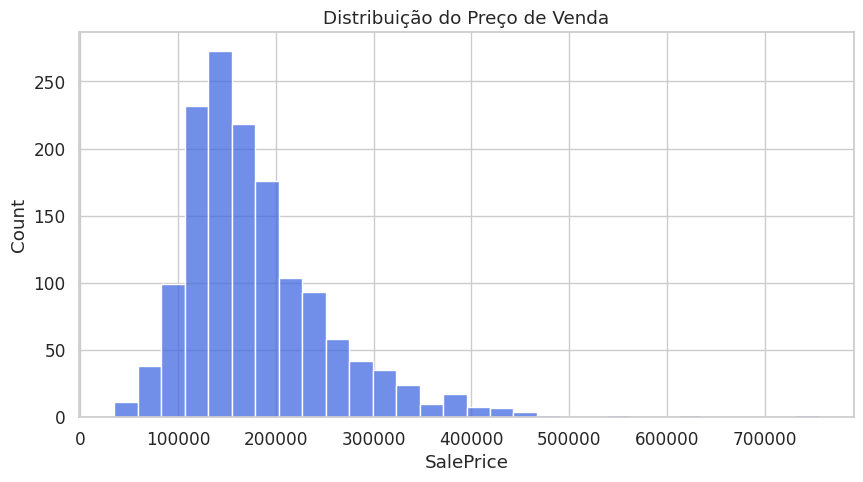

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df["SalePrice"], bins=30, color="royalblue")
plt.title("Distribuição do Preço de Venda")
plt.show()

```markdown
🔍 **Observação:** A variável `SalePrice` apresenta uma assimetria positiva. Isso pode ser tratado com transformação logarítmica na modelagem.
```

---

## 🧱 4. Gráficos por Variável

### 🔹 Variáveis Numéricas

#### `GrLivArea` vs `SalePrice`

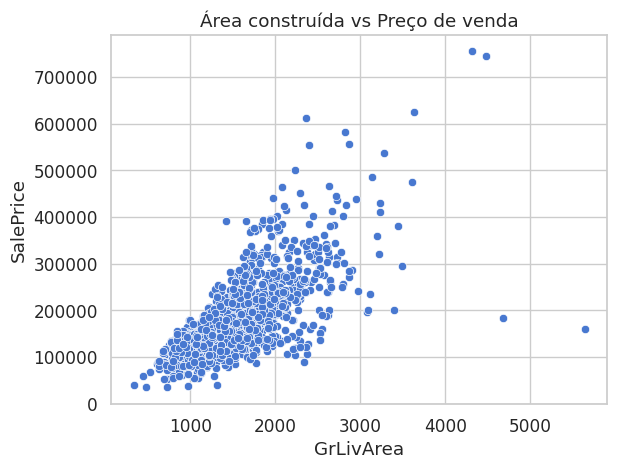

In [12]:
sns.scatterplot(x="GrLivArea", y="SalePrice", data=df)
plt.title("Área construída vs Preço de venda")
plt.show()

```markdown
**Observação:** A variável `GrLivArea` apresenta alguns possívies outliers

```
#### `TotalBsmtSF` vs `SalePrice`

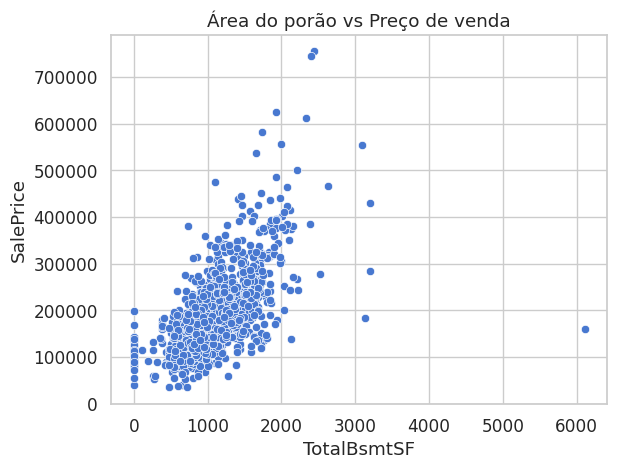

In [13]:
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=df)
plt.title("Área do porão vs Preço de venda")
plt.show()

#### `GarageArea` vs `SalePrice`


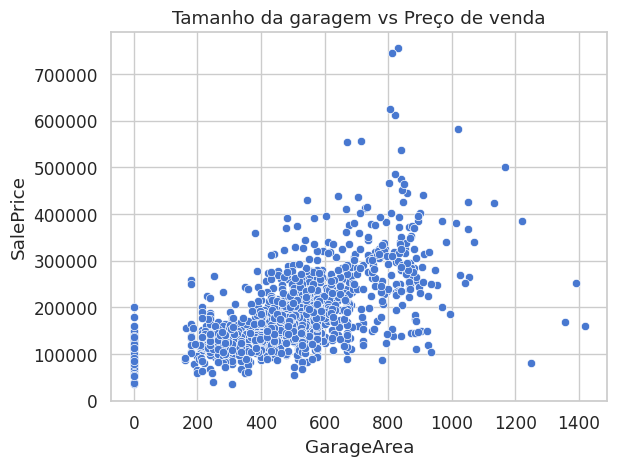

In [14]:
sns.scatterplot(x="GarageArea", y="SalePrice", data=df)
plt.title("Tamanho da garagem vs Preço de venda")
plt.show()

### 🔸 Variáveis Categóricas


#### `OverallQual` (Qualidade Geral)


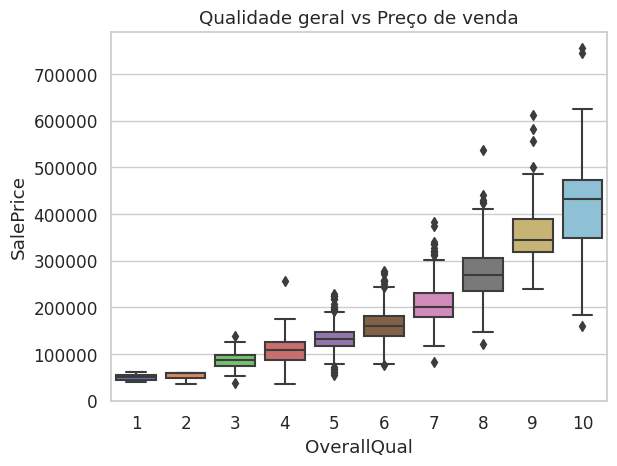

In [18]:
sns.boxplot(x="OverallQual", y="SalePrice", data=df)
plt.title("Qualidade geral vs Preço de venda")
plt.show()

#### `Neighborhood`


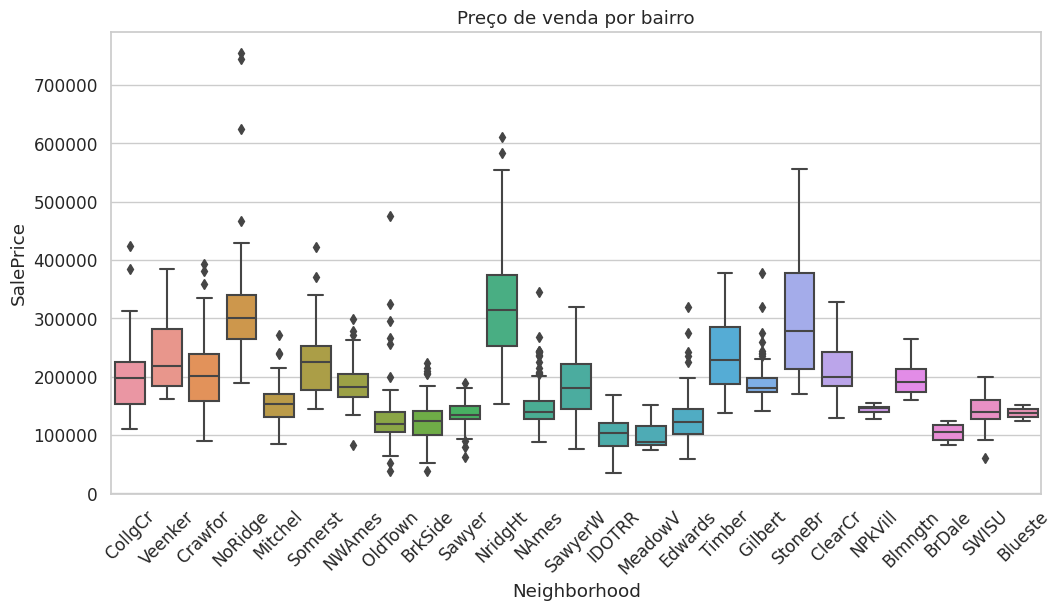

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=df)
plt.xticks(rotation=45)
plt.title("Preço de venda por bairro")
plt.show()


```markdown
**Observação:** A variável `Neighborhood` apresenta alguns possívies outliers

```

#### `ExterQual`


In [ ]:
sns.boxplot(x="ExterQual", y="SalePrice", data=df, order=["Po", "Fa", "TA", "Gd", "Ex"])
plt.title("Qualidade externa vs Preço de venda")
plt.show()

---

## 🚨 5. Análise de Outliers

### Outliers em `GrLivArea`